<a href="https://colab.research.google.com/github/LaitNoisette/ISEP-Skin-Lesion-Classification/blob/master/Saliency_Map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python

In [0]:
import cv2
from google.colab.patches import cv2_imshow

from scipy.spatial import distance
import numpy as np

from sklearn.metrics.pairwise import euclidean_distances
from scipy import signal

import matplotlib.pyplot as plt

import glob

import random

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


#Class Saliency Map

In [0]:
class SaliencyMap():
  im=None
  imCieLab=None
  imGTS=None
  imsFS=None
  contours=None
  hierarchy=None
  contourChoose=None
  imRoi=None
  imRoiPadding=None

  def __init__(self,im,imPath):
    if imPath==True:
      self.im=cv2.imread(im)
    else:
      self.im=im
    self.imCieLab=cv2.cvtColor(self.im,cv2.COLOR_BGR2Lab)

#Part1 : GTS Global Tomographical Surface
  def oneChannelGlobalContrast(self):
    sGC1channel = np.zeros(shape=(self.imCieLab.shape[0],self.imCieLab.shape[1]))
    for channel,channel_mean in zip(cv2.split(self.imCieLab),cv2.mean(self.imCieLab)):
      sGC1channel=sGC1channel+((channel-channel_mean)**2)
    return sGC1channel
  
  def IterativeLaplacianOfGaussian(self):
    def LaplacianOfGaussian(im,stdDev):
      imGaussian=cv2.GaussianBlur(im,(0,0),stdDev,stdDev)
      imLaplacianOfGaussian=cv2.Laplacian(cv2.cvtColor(imGaussian, cv2.COLOR_BGR2GRAY),im.dtype.num)
      return imLaplacianOfGaussian

    im=np.uint8(self.imCieLab)
    stdDev = np.std(im)
    laplacianOfGaussianTheta = 0.05
    laplacianOfGaussianIteration = 0.4
    imILoG = np.zeros(shape=(im.shape[0], im.shape[1]))
    while laplacianOfGaussianIteration <= (0.6):
      imILoG = imILoG+LaplacianOfGaussian(im, stdDev + laplacianOfGaussianIteration) 
      laplacianOfGaussianIteration += laplacianOfGaussianTheta
    return imILoG
  
  def generateImGTS(self):
    self.imGTS=self.oneChannelGlobalContrast()+self.IterativeLaplacianOfGaussian()

#Part 2 : Regional Saliencies Integration
## K-Means Algorithm

  #Function use to binarize a picture (K-means set to 2 cluster)
  def binarizationKmeans(self,im,K=2):
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 3, 1.0)

    #Test Channel existance (color image)
    if(len(im.shape)==3):
      #Image Multiple channel
      Z = im.reshape((-1,im.shape[2]))
    else:
      #Gray picture
      Z = im.reshape((-1))

    # convert to np.float32
    Z = np.float32(Z)

    ret,label,center=cv2.kmeans(Z,K,None,criteria,3,cv2.KMEANS_RANDOM_CENTERS)
    #ret,label,center=cv2.kmeans(Z,K,None,criteria,3,cv2.KMEANS_PP_CENTERS)
    return ret,label,center

  #Function to generate the Binarize picture 
  def generateKmeansPicture(im,K=2,center=None,label=None):
    ret,label,center=binarizationKmeans(im,K)
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((im.shape))
    return res2

  #Function to get the cluster class (label) from a cluster center region
  def getClusterClassFromCenter(currentCenter,centerGlobal,labelGlobal):
    #Cluster class table (relation between the label class and the region)
    clusterClassTable=centerGlobal[labelGlobal.flatten()]

    #Look for the center region in cluster table
    centerIndexClusterTable=np.where(clusterClassTable==currentCenter)

    #Test if any results found
    if any(centerIndexClusterTable[0]):
      #get pixel index of the first result found
      centerIndexCluster=centerIndexClusterTable[0][0]
      
      #return cluster class (label)
      return (labelGlobal[centerIndexCluster])
    return None

  def getRegionPicture(im,cluster):
    ret,label,center=binarizationKmeans(im)
    return generateMaskClusterPicture(center,label,cluster,im)


  def generateMaskClusterPicture(self,center,label,cluster,im):
      #Function use to mask one cluster on a Picture (set the pixel to black)
    def maskClusterToPicture(center,label,cluster):
      #center = np.uint8(center)
      clusterPixel=center[label.flatten()]

      #Set the pixel value not equal to the cluster region to 0
      #The shape of array is based on the number of channel of the picture (number of column)
      clusterPixel[label.flatten()!=cluster]=np.zeros_like(clusterPixel.shape[1])
      return clusterPixel
    
    def reshapePictureArrayToPictureShape(picturePixelArray,im):
      return picturePixelArray.reshape(im.shape)

    clusterPixel=maskClusterToPicture(center,label,cluster)
    maskClusterPicture = reshapePictureArrayToPictureShape(clusterPixel,im)
    return maskClusterPicture


  def gaussianFunction(x):
    return np.exp(-np.power(x,2))

## Center Position Picture
  def centerPositionPicture(w,h):
    return (w/2,h/2)

  def centerPositionRegionPicture(imR):
    indexRegion=np.where(imR!=0)
    minIndexW=indexRegion[0][0]
    maxIndexW=indexRegion[0][-1]
    minIndexH=indexRegion[1][0]
    maxIndexH=indexRegion[1][-1]

    centerPosPic=centerPositionPicture(maxIndexW-minIndexW,maxIndexH-minIndexH)

    return(minIndexW+centerPosPic[0],minIndexH+centerPosPic[1])

## iFactor
  def iFactor(im,imRegion,maxEuclideanDistanceGTS,minEuclideanDistanceGTS,regionEuclideanDistanceGTS):
    posK=centerPositionRegionPicture(imRegion)
    posC=centerPositionPicture(im.shape[0],im.shape[1])
    nK=np.sum(imRegion.flatten()!=0)

    iFactor=0
    if maxEuclideanDistanceGTS!=minEuclideanDistanceGTS:
      gtsW=np.power(maxEuclideanDistanceGTS-regionEuclideanDistanceGTS,1.0/(maxEuclideanDistanceGTS-minEuclideanDistanceGTS))
      iFactor=(gaussianFunction(distance.euclidean(posK,posC))/nK)*gtsW

    return iFactor

## Regional Saliency Integration

  def optimalKforKmeans(im):
    if(len(im.shape)==3):
      im=im.reshape((im.shape[0]*im.shape[1],im.shape[2]))
    kmax=2
    sil=[]
    kReturn=2
    for k in range(2, kmax+1):
      kReturn=k
      kmeans = KMeans(n_clusters = k).fit(im)
      labels = kmeans.labels_
      sScore=silhouette_score(im, labels, metric = 'euclidean')
      maxIndex=len(sil)
      if(maxIndex>0):
        if(sScore<sil[maxIndex-1]):
          return kReturn-1
      sil.append(sScore)
    return kReturn

  def getKmeanClusterFromPictureResolution(self,im):
    imSize=np.int32(im.shape[1])*np.int32(im.shape[0])
    if imSize<=(1000*500):
      return 9
    elif imSize<=(2000*1000):
      return 8
    elif imSize<=(4000*2000):
      return 7
    elif imSize<=(6000*3000):
      return 6
    elif imSize<=(8000*4000):
      return 5
    else:
      return 4

  def regionalSaliencyIntegration(self,K=2):
    ##Areal
    #Function to calcultate the regional Areal Density of picture region :
    #Pixel in region picture/Total pixel of the picture
    def regionalArealDensity(imR,im):
      return np.sum(imR.flatten()!=0)/len(im.flatten())

    # Euclidean Distance
    def einsumEuclideanDistance(v, u):
      z = v - u
      return np.sqrt(np.einsum('ij,ij->ij', z, z))
    def einsumEuclideanDistance3D(v, u):
      z = v - u
      return np.sqrt(np.einsum('ijk,ijk->ij', z, z))

    ## SRC/SRCC
    def SRC_GTS_Color(aReal,dis0,dis_GTS_color,sigmaModulo=10):
      if aReal!=None:
        sigma=np.power(10,np.log10(dis0))
        return aReal*np.exp((dis0/np.power(sigma,2)))*dis_GTS_color
      return 0

    #Function to calculate the SRC
    def saliencyRegionalContrast(imGTS,imGTSRk,imGTSRj,dis0):
      aReal=regionalArealDensity(imGTSRj,imGTS)
      
      disGTS=einsumEuclideanDistance(imGTSRk,imGTSRj)
      
      src=SRC_GTS_Color(aReal,dis0,disGTS)
      return src

    #Function to calculate SRCC
    def saliencyRegionalColorContrast(im,imRk,imRj,dis0): 
      aReal=regionalArealDensity(imRj,im)
      
      disColor=einsumEuclideanDistance3D(imRk,imRj)
      
      srcc=SRC_GTS_Color(aReal,dis0,disColor)
      return srcc

      ## Gaussian Function
    def gaussianFunctionPicture(im):
      im=np.uint8(im)
      stdDev = np.std(im)
      imGaussian=cv2.GaussianBlur(im,(0,0),stdDev,stdDev)
      return np.uint8(imGaussian)

    im=self.imCieLab
    imGTS=self.imGTS

    K=self.getKmeanClusterFromPictureResolution(im)
    print(K)

    retIm,labelIm,centerIm=self.binarizationKmeans(im,K)
    retImGTS,labelImGTS,centerImGTS=self.binarizationKmeans(imGTS,K)

    sFS=np.zeros_like(imGTS,dtype=None)

    maxEuclideanDistanceGTS=None
    minEuclideanDistanceGTS=None

    for k in range(K):
      src=np.zeros_like(imGTS,dtype=None)
      srcc=np.zeros_like(imGTS,dtype=None)

      imRk=self.generateMaskClusterPicture(centerIm,labelIm,k,im)
      imGTSRk=self.generateMaskClusterPicture(centerImGTS,labelImGTS,k,imGTS)

      for j in range(K):
        if j!=k:
          imRj=self.generateMaskClusterPicture(centerIm,labelIm,j,im)
          imGTSRj=self.generateMaskClusterPicture(centerImGTS,labelImGTS,j,imGTS)

          dis0=distance.euclidean(imGTSRk.flatten(),imGTSRj.flatten())
          if maxEuclideanDistanceGTS==None:
            maxEuclideanDistanceGTS=dis0
          elif dis0>maxEuclideanDistanceGTS:
            maxEuclideanDistanceGTS=dis0

          if minEuclideanDistanceGTS==None:
            minEuclideanDistanceGTS=dis0
          elif dis0<minEuclideanDistanceGTS:
            minEuclideanDistanceGTS=dis0

          src=src+saliencyRegionalContrast(imGTS,imGTSRk,imGTSRj,dis0)
          srcc=srcc+saliencyRegionalColorContrast(im,imRk,imRj,dis0)

      sFS=np.uint8(sFS)+gaussianFunctionPicture(src+srcc)
    return sFS
  
  def generateImsFS(self):
    self.imsFS=self.regionalSaliencyIntegration()

##Part3 : ROI Extraction
  def getPictureCenter(self,im):
    return (int(im.shape[1]/2),int(im.shape[0]/2))

  def drawCircleCenterPicture(im):
    return cv2.circle(im,getPictureCenter(im),10,(255,0,0),thickness=10)

  def getMaxAreaContour(self,contours):
    contour=[]
    area=0
    indexContour=0
    contourNumber=0
    for c in contours:
      tmpArea=cv2.contourArea(c)
      if(tmpArea>area):
        contour=c
        area=tmpArea
        contourNumber=indexContour
      indexContour+=1
    return contour,contourNumber,area

  def getContourCenter(self,contour):
    #Create bounding box from Rectangle
    x,y,w,h = cv2.boundingRect(contour)
    cX=int(x+w/2)
    cY=int(y+h/2)
    return cX,cY

  def getClosestContourOriginFromCenter(self,contour,center):
    #Create bounding box from Rectangle
    x,y,w,h = cv2.boundingRect(contour)
    coordBoundingBox=(x,y)
    dFromCenter=distance.euclidean(center,(x,y))
    if(dFromCenter>distance.euclidean(center,(x+w,y))):
      dFromCenter=distance.euclidean(center,(x+w,y))
      coordBoundingBox=(x+w,y)
    if(dFromCenter>distance.euclidean(center,(x,y+h))):
      dFromCenter=distance.euclidean(center,(x,y+h))
      coordBoundingBox=(x,y+h)
    if(dFromCenter>distance.euclidean(center,(x+w,y+h))):
      dFromCenter=distance.euclidean(center,(x+w,y+h))
      coordBoundingBox=(x+w,y+h)
    return coordBoundingBox

  def getParentOrChildContour(self,contours,contourNumber,treeHierarchy,parentGeneration=1,centerTolerance=0.5):
    index=0
    maxAreaContour,maxAreaContourNumber,maxAreaContourValue=self.getMaxAreaContour(contours)
    parentContourNumber=treeHierarchy[0][contourNumber][3]
    sameLevelContoursList=contours[contourNumber]

    cX,cY=self.getContourCenter(contours[contourNumber])
    contourCenter=(int(cX),int(cY))

    #Look for parent and contourNumber==maxAreaContourNumber
    #maxAreaContourNumber!=parentContourNumber and
    if parentContourNumber!=-1:
      print('Parent Path')
      #and maxAreaContourNumber!=parentContourNumber)
      #
      while(index<parentGeneration and parentContourNumber!=-1):
        index+=1
        parentContourNumber=treeHierarchy[0][contourNumber][3]
        #print(parentContourNumber)
        if parentContourNumber!=-1:
          contourNumber=parentContourNumber
          # if maxAreaContourNumber!=parentContourNumber:
          #   contourNumber=parentContourNumber
      return contours[contourNumber]
    #Look for contours in the same level, concat them
    else :
      print('Same Level Path')
      # print(np.sqrt(maxAreaContourValue))
      # print((np.sqrt(maxAreaContourValue)*centerTolerance))

      # if contourNumber==maxAreaContourNumber:
      #   childContour=treeHierarchy[0][contourNumber][2]
      #   if childContour!=-1:
      #     contourNumber=childContour
      #     sameLevelContoursList=contours[contourNumber]

      print('Contour Number:')
      print(contourNumber)
      previousContourNumberSameLevel=treeHierarchy[0][contourNumber][1]
      nextContourNumberSameLevel=treeHierarchy[0][contourNumber][0]

      
      #Previous contours in the same level
      while(previousContourNumberSameLevel!=-1):
        # cXsameLevel,cYsameLevel=getContourCenter(contours[previousContourNumberSameLevel])
        # contourCenterSameLevel=(int(cXsameLevel),int(cYsameLevel))
        contourCenterSameLevel=self.getClosestContourOriginFromCenter(contours[previousContourNumberSameLevel],contourCenter)
        if distance.euclidean(contourCenter,contourCenterSameLevel)<(np.sqrt(maxAreaContourValue)*centerTolerance):
          # print(distance.euclidean(contourCenter,contourCenterSameLevel))
          sameLevelContoursList=np.append(sameLevelContoursList,contours[previousContourNumberSameLevel])
        previousContourNumberSameLevel=treeHierarchy[0][previousContourNumberSameLevel][1]
        
      #Next contours in the same level
      while(nextContourNumberSameLevel!=-1):
        # cXsameLevel,cYsameLevel=getContourCenter(contours[nextContourNumberSameLevel])
        # contourCenterSameLevel=(int(cXsameLevel),int(cYsameLevel))    
        contourCenterSameLevel=self.getClosestContourOriginFromCenter(contours[nextContourNumberSameLevel],contourCenter)
        if distance.euclidean(contourCenter,contourCenterSameLevel)<(np.sqrt(maxAreaContourValue)*centerTolerance):
          #print(distance.euclidean(contourCenter,contourCenterSameLevel))
          sameLevelContoursList=np.append(sameLevelContoursList,contours[nextContourNumberSameLevel])
        nextContourNumberSameLevel=treeHierarchy[0][nextContourNumberSameLevel][0]
      
      sameLevelContoursList=sameLevelContoursList.reshape(-1,2)
      return sameLevelContoursList

    return contours[contourNumber]

  #Function to isolate the contour the closest to the center of the picture
  def selectContourCenterPicture(self,parentGeneration=1,centerTolerance=0.5):
    imCenter=self.getPictureCenter(self.im)
    # print("imCenter")
    # print(imCenter)
    dCenter=None
    self.contourChoose=None
    contourNumber=0
    contourIndex=0

    maxAreaContour,maxAreaContourNumber,maxAreaContourValue=self.getMaxAreaContour(self.contours)

    for c in self.contours:
  
      euclidDistance=distance.euclidean(imCenter,self.getClosestContourOriginFromCenter(c,imCenter))
      if dCenter==None:
        dCenter=euclidDistance
        self.contourChoose=c
        contourNumber=contourIndex
        
      if euclidDistance<dCenter:
        dCenter=euclidDistance
        self.contourChoose=c
        contourNumber=contourIndex

      contourIndex+=1
      
    
    if parentGeneration>0:
      self.contourChoose=self.getParentOrChildContour(self.contours,contourNumber,self.hierarchy,parentGeneration,centerTolerance)
    
    return self.contourChoose,contourNumber

  def extractContourRegionFromPicture(self,borderType=cv2.BORDER_CONSTANT):
    x,y,w,h = cv2.boundingRect(self.contourChoose)
    self.imRoi=np.copy(self.im[y:y+h,x:x+w])

  def extractContourRegionFromPictureWithPadding(self,patchSize,borderType=cv2.BORDER_CONSTANT):
    x,y,w,h = cv2.boundingRect(self.contourChoose)
    imCrop=np.copy(self.im[y:y+h,x:x+w])
    rX=np.mod(imCrop.shape[0],patchSize)
    rY=np.mod(imCrop.shape[1],patchSize)

    topBottomPadding=0
    leftRightPadding=0

    while(rX!=0):
      topBottomPadding+=1
      imCropPad=cv2.copyMakeBorder(imCrop,topBottomPadding,topBottomPadding,0,0,cv2.BORDER_CONSTANT)
      rX=np.mod(imCropPad.shape[0],patchSize)
    
    while(rY!=0):
      leftRightPadding+=1
      imCropPad=cv2.copyMakeBorder(imCrop,0,0,leftRightPadding,leftRightPadding,cv2.BORDER_CONSTANT)
      rY=np.mod(imCropPad.shape[1],patchSize)
    
    self.imRoiPadding=cv2.copyMakeBorder(imCrop,topBottomPadding,topBottomPadding,leftRightPadding,leftRightPadding,borderType)
    return self.imRoiPadding

  def drawContoursCenter(im,contours):
    for c in contours:
      cX,cY=getContourCenter(c)
      # draw the contour and center of the shape on the image
      cv2.drawContours(im, [c], -1, (0, 255, 0), 2)
      cv2.circle(im, (cX, cY), 7, (255, 255, 255), -1)
      cv2.putText(im, "center", (cX - 20, cY - 20),
      cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
      # show the image
      imShowScale(im,5)
      #cv2.imshow("Image", im)
      cv2.waitKey(0)

  def getContoursList(self):
    threshMap = cv2.threshold(np.uint8(self.imsFS).astype("uint8"), 0, 255,
    cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    contours, hierarchy = cv2.findContours(threshMap, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    self.contours=contours
    self.hierarchy=hierarchy

# Part1 : GTS Global Tomographical Surface

GTS = GC+ ILG

In [0]:
def imShowScale(im,scale=10):
    cv2_imshow(cv2.resize(im,(int(im.shape[1]/scale),int(im.shape[0]/scale))))

In [0]:
picturePath=''

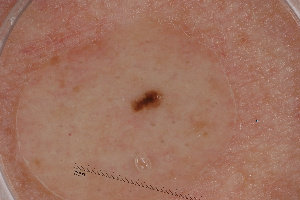

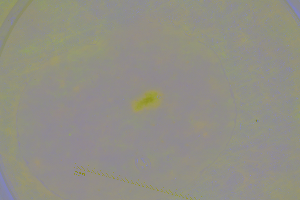

In [7]:
saliencyMap=SaliencyMap(picturePath,True)
imShowScale(saliencyMap.im)
imShowScale(saliencyMap.imCieLab)

## GTS =Central Global Contrast + ILG (Iterative Laplacian of Gaussian)

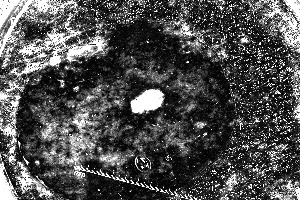

In [8]:
saliencyMap.generateImGTS()
imShowScale(saliencyMap.imGTS)

# Part 2 : Regional Saliencies Integration

## K-Means Algorithm

## Areal

## Euclidean Distance

## SRC/SRCC

## Gaussian Function

## Center Position Picture

## iFactor

## Regional Saliency Integration

7


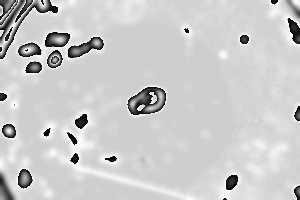

In [9]:
saliencyMap.generateImsFS()
imShowScale(saliencyMap.imsFS)

In [0]:
#sFS=regionalSaliencyIntegration(imTestCieLab,np.uint8(imTestGTS))

#ROI Extraction

In [11]:
saliencyMap.getContoursList()
saliencyMap.selectContourCenterPicture(1,0.5)
saliencyMap.extractContourRegionFromPicture()

Parent Path


In [14]:
imShowScale(saliencyMap.imRoi)

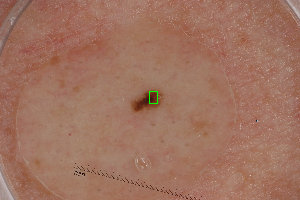

In [17]:
x,y,w,h = cv2.boundingRect(saliencyMap.contourChoose)
picCopy = cv2.rectangle(saliencyMap.im,(x,y),(x+w,y+h),(0,255,0),10)
imShowScale(picCopy)

# Results

In [16]:
# imShowScale(imTest,5)
# imShowScale(np.uint8(sFS),5)
# imShowScale(threshMap,5)

NameError: ignored

In [0]:
# picCopy=np.copy(imTest)
# drawCircleCenterPicture(picCopy)
# imShowScale(cv2.drawContours(picCopy, contours, -1, (255,255,125),10),5)
# print("Image with all Contours")

# contour=getMaxAreaContour(contours)[0]

# picCopy=np.copy(imTest)
# drawCircleCenterPicture(picCopy)
# imShowScale(cv2.drawContours(picCopy,contour, -1, (255,255,125),10),5)
# print("Image with largest area Contours")

# picCopy=np.copy(imTest)
# drawCircleCenterPicture(picCopy)
# x,y,w,h = cv2.boundingRect(contour)
# picCopy = cv2.rectangle(picCopy,(x,y),(x+w,y+h),(0,255,0),10)
# imShowScale(picCopy,5)
# print("Image with largest area Contours : Box")


# picCopy=np.copy(imTest)
# drawCircleCenterPicture(picCopy)
# contourCenter,cNumber=selectContourCenterPicture(contours,imTest,hierarchy,0)
# x,y,w,h = cv2.boundingRect(contourCenter)
# picCopy = cv2.rectangle(picCopy,(x,y),(x+w,y+h),(0,255,0),10)
# imShowScale(picCopy,5)
# print(cNumber)
# print("Image with center contour with no parent generation")

# picCopy=np.copy(imTest)
# drawCircleCenterPicture(picCopy)
# contourCenter,cNumber=selectContourCenterPicture(contours,imTest,hierarchy,1,0.5)
# x,y,w,h = cv2.boundingRect(contourCenter)
# picCopy = cv2.rectangle(picCopy,(x,y),(x+w,y+h),(0,255,0),10)
# imShowScale(picCopy,5)
# print(cNumber)
# print("Image with center contour with 1 parent generation")

In [0]:
patchS=7

In [0]:
imROIpadding=extractContourRegionWithPadding(imTest,contourCenter,patchS)

In [0]:
imShowScale(imROIpadding,5)

In [0]:
def extractOverlappingPatchListFromROI(im,contourCenter,patchSize,borderType=cv2.BORDER_CONSTANT):
  roiPadding=extractContourRegionFromPictureWithPadding(im,contourCenter,patchSize,borderType)
  maxXpos=roiPadding.shape[0]
  maxYpos=roiPadding.shape[1]

  baseX=0
  baseY=0

  listPatch=[]
  while(baseX+patchSize<=maxXpos):
    while(baseY+patchSize<=maxYpos):
      listPatch.append(roiPadding[baseX:baseX+patchSize,baseY:baseY+patchSize])
      baseY+=patchSize
    baseX+=patchSize
  return np.array(listPatch)